In [1]:
import gym


def one_hot_vector(i, n):
    x = np.zeros(n)
    x[i] = 1
    return x


def to_bits(i, n):
    """ dense binary representation of a one-hot encoded vector of size n """
    nbits = int(np.ceil(np.log2(n)))
    b = "{:032b}".format(i)
    return b[-nbits:]


def X(s, a):
    """ map state-action pair to int (unique, dense) """
    x = "".join(
        [to_bits(a, env.action_space.n)] +
        [to_bits(i, sp.n) for i, sp in zip(s, env.observation_space.spaces)])
    return int(x, 2)


def init_Q(env, scale=0):
    dim = 2 ** (
        int(np.ceil(np.log2(env.action_space.n))) +
        sum(int(np.ceil(np.log2(sp.n))) for sp in env.observation_space.spaces))
    return scale * np.ones(dim)


def epsilon_greedy(Q, s, epsilon):
    if np.random.rand() < epsilon:
        return env.action_space.sample()
    
    Q_a = [Q[X(s, a)] for a in (0, 1)]
    a = np.argmax(Q_a)
    return a

def process_performance(performance):
    # postprocess performance
    df = pd.DataFrame(performance, columns=('lose', 'draw', 'win'))
    df.index.name = 'episode'
    tmp = df.rolling(1000).sum().iloc[1000:]
    tmp = tmp.div(tmp.sum(axis=1), axis=0)
    display(tmp.iloc[[-1]].T)

    # plot
    tmp['draw'] += tmp['win']
    tmp['lose'] += tmp['draw']
    ax = tmp.plot(y='win')
    ax.fill_between(tmp.index, tmp['win'], alpha=0.5)
    tmp.plot(y='draw', ax=ax)
    ax.fill_between(tmp.index, tmp['win'], tmp['draw'], alpha=0.5)
    tmp.plot(y='lose', ax=ax)
    ax.fill_between(tmp.index, tmp['draw'], tmp['lose'], alpha=0.5)

# Create a baseline

For this, we set `epsilon` to 1, i.e. only random exploration.

episode,9999
lose,0.655
draw,0.045
win,0.300


CPU times: user 1.04 s, sys: 24.6 ms, total: 1.07 s
Wall time: 1.06 s


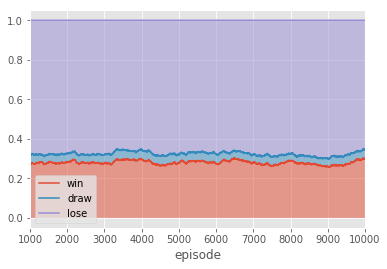

In [2]:
%%time

# parameters
gamma = 1.0
num_episodes = 10000
first_visit_update = False


# initialize
env = gym.make('Blackjack-v0')
Q = init_Q(env, scale=10)
N = np.zeros_like(Q)


# keep track of performance
performance = []


for episode in range(1, num_episodes + 1):

    # init
    s = env.reset()
    episode_cache = []
    
    # amount of random exploration
    epsilon = 1
    
    done = False
    while not done:
        a = epsilon_greedy(Q, s, epsilon)
        s_next, r, done, info = env.step(a)

        # store experience
        episode_cache.append((X(s, a), r))
    
        # prepare for next step
        s = s_next
    
    j = 1 + int(r)  # 0: loss, 1: draw, 2: win
    performance.append(one_hot_vector(j, 3))
    
    # unroll episode experience
    G = 0.0
    while episode_cache:
        i, r = episode_cache.pop()
        G = r + gamma * G
        
        # hold off on update if an earlier i exists
        if first_visit_update and i in dict(episode_cache):
            continue
        
        N[i] += 1
        Q[i] += (G - Q[i]) / N[i]

env.close()

process_performance(performance)

# Create a benchmark

Same as above, but with `epsilon` starting at 1 and linearly degrading over time.

episode,9999
lose,0.518
draw,0.059
win,0.423


CPU times: user 1.64 s, sys: 62.8 ms, total: 1.7 s
Wall time: 1.6 s


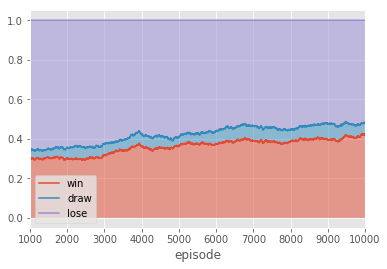

In [3]:
%%time

# parameters
gamma = 1.0
num_episodes = 10000
first_visit_update = False


# initialize
env = gym.make('Blackjack-v0')
Q = init_Q(env, scale=10)
N = np.zeros_like(Q)


# keep track of performance
performance = []


for episode in range(1, num_episodes + 1):

    # init
    s = env.reset()
    episode_cache = []
    
    # amount of random exploration
    epsilon = np.clip(1 - episode / (0.8 * num_episodes), 0, 1)
    
    done = False
    while not done:
        a = epsilon_greedy(Q, s, epsilon)
        s_next, r, done, info = env.step(a)

        # store experience
        episode_cache.append((X(s, a), r))
    
        # prepare for next step
        s = s_next
    
    j = 1 + int(r)  # 0: loss, 1: draw, 2: win
    performance.append(one_hot_vector(j, 3))
    
    # unroll episode experience
    G = 0.0
    while episode_cache:
        i, r = episode_cache.pop()
        G = r + gamma * G
        
        # hold off on update if an earlier i exists
        if first_visit_update and i in dict(episode_cache):
            continue
        
        N[i] += 1
        Q[i] += (G - Q[i]) / N[i]

env.close()

process_performance(performance)


# Now let's try the keras_gym version

This version is slower than the benchmark. I need to look into this.

episode,9999
lose,0.473
draw,0.082
win,0.445


CPU times: user 30.5 s, sys: 2.36 s, total: 32.9 s
Wall time: 26.4 s


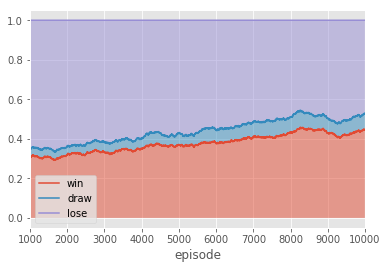

In [4]:
%%time

import gym

from tensorflow import keras

from keras_gym.value_functions import LinearQ
from keras_gym.policies import ValuePolicy
from keras_gym.algorithms import MonteCarloQ



# the Gym environment
env = gym.make('Blackjack-v0')


# define Q, its induced policy and update algorithm
Q = LinearQ(env, optimizer=keras.optimizers.Adagrad(lr=0.1))
policy = ValuePolicy(Q)
algo = MonteCarloQ(Q, gamma=1)


# number of iterations
num_episodes = 10000
max_episode_steps = 100


# used for early stopping
performance = []


for episode in range(1, num_episodes + 1):
    
    # init
    s = env.reset()
    
    # amount of random exploration
    epsilon = np.clip(1 -  episode / (0.8 * num_episodes), 0, 1)
    
    done = False
    while not done:
        a = policy.epsilon_greedy(s, epsilon)
        s_next, r, done, info = env.step(a)
        
        # update
        algo.update(s, a, r, s_next, done)         
    
        # prepare for next step
        s = s_next
        
    j = 1 + int(r)  # 0: loss, 1: draw, 2: win
    performance.append(one_hot_vector(j, 3))


env.close()
process_performance(performance)
